In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import esda
from esda.moran import Moran, Moran_Local

import libpysal as lps

import pysal
import pysal.lib.weights as weights

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

import os
GEODATA_PATH = 'data/geodata/'
OUTPUT_PATH = 'data/output/'

In [2]:
brgys_geodata = gpd.read_file(GEODATA_PATH+'AdministrativeBoundariesBARMMBarangays20190206PSA2016/AdministrativeBoundariesBARMMBarangays20190206PSA2016.shp')
cond = brgys_geodata['Reg_Code']=='PH150000000'
brgys_geodata = brgys_geodata.to_crs("EPSG:4326")
brgys_geodata=brgys_geodata[cond].reset_index(drop=True)
print("brgys_geodata",brgys_geodata.shape)

schools_geodata = gpd.read_file(OUTPUT_PATH+'SchoolsDepEd2017_Geodata_Clean/SchoolsDepEd2017_Geodata_Clean.shp')
print("schools_geodata",schools_geodata.shape)

pop_sdg_df = pd.read_csv(OUTPUT_PATH+"Population_Schools_SDGs_Clean.csv",
                         usecols=["PSGC_BRGY","total_popn","both_age_6_to_16","No_of_Schools"])
print("pop_sdg_df",pop_sdg_df.shape)

brgys_popn = brgys_geodata.merge(pop_sdg_df,left_on="Bgy_Code",right_on="PSGC_BRGY",how='left')
brgys_popn.drop(columns=["Bgy_Code"],inplace=True)
print("brgys_popn",brgys_popn.shape)

brgys_geodata (2489, 9)
schools_geodata (2711, 13)
pop_sdg_df (2482, 4)
brgys_popn (2489, 12)


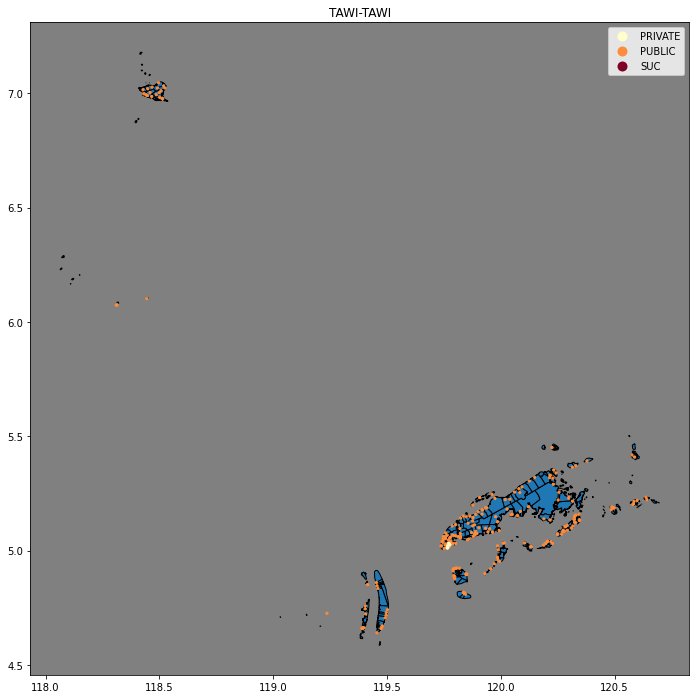

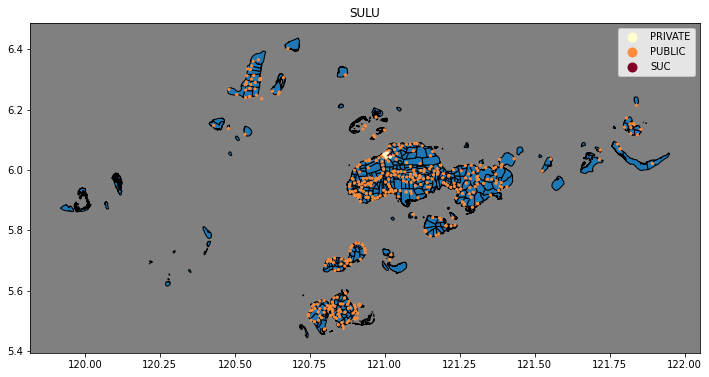

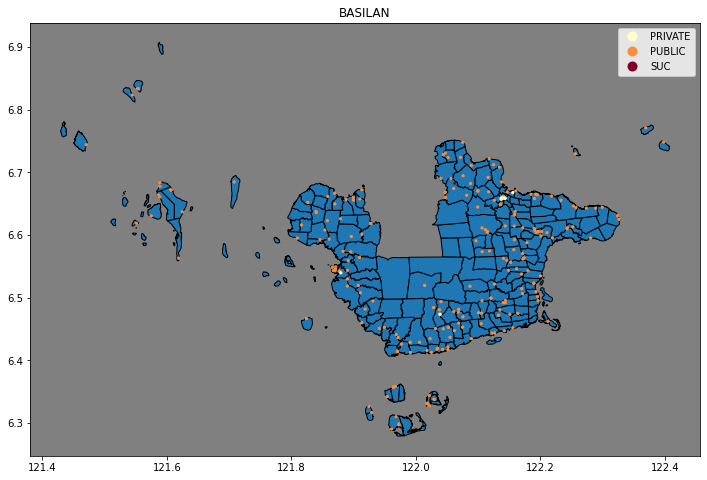

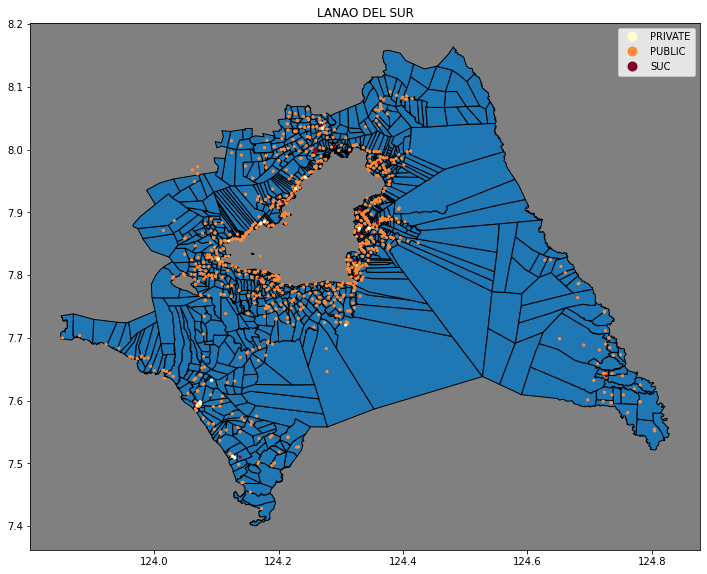

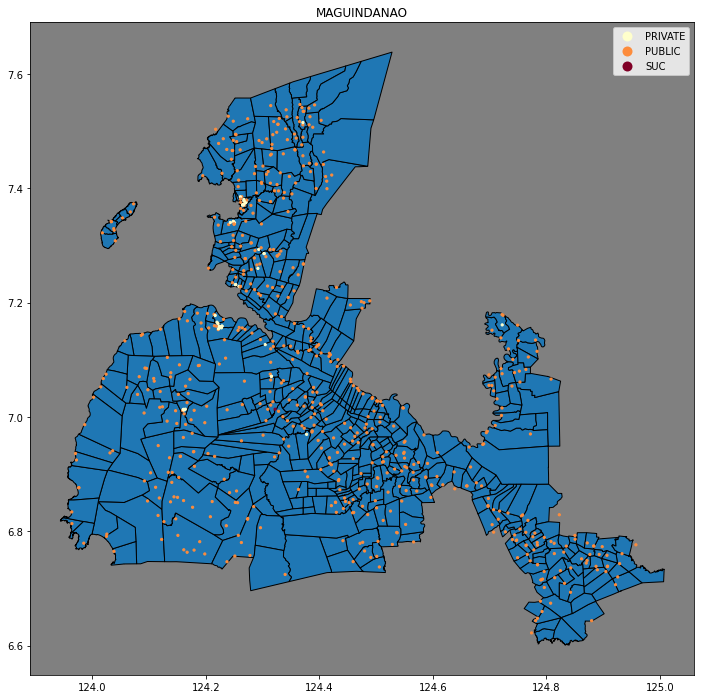

In [3]:
for province in brgys_geodata['Pro_Name'].unique():
    cond = brgys_geodata['Pro_Name']==province
    base = brgys_geodata[cond].plot(figsize=(12, 12),
                                    edgecolor="k")
    
    cond = schools_geodata['PROV']==province
    schools_geodata[cond].dropna()\
                         .plot(ax=base,
                               markersize=5,
                               column="SCH_TYPE",
                               cmap="YlOrRd",
                               legend=True)
    base.set_facecolor('grey')
    plt.title(province)
    plt.show();

('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 80, ' is an island (no neighbors)')
('WARNING: ', 86, ' is an island (no neighbors)')
('WARNING: ', 100, ' is an island (no neighbors)')
('WARNING: ', 101, ' is an island (no neighbors)')
('WARNING: ', 106, ' is an island (no neighbors)')
('WARNING: ', 115, ' is an island (no neighbors)')
('WARNING: ', 124, ' is an island (no neighbors)')
('WARNING: ', 254, ' is an island (no neighbors)')
('WARNING: ', 284, ' is an island (no neighbors)')
('WARNING: ', 285, ' is an island (no neighbors)')
('WARNING: ', 286, ' is an island (no neighbors)')
('WARNING: ', 287, ' is an island (no neighbors)')
('WARNING: ', 355, ' is an island (no neighbors)')
('WARNING: ', 356, ' is an island (no neighbors)')
('WARNING: ', 363, ' is an island (no neighbors)')
('WARNING: ', 502, ' is an island (no neighbors)')
('WARNING: ', 513, ' is an island (no neighbors)')
('WARNING: ', 528, ' is an island (no neighbors)')
('WARNING: ', 575, ' is an island 

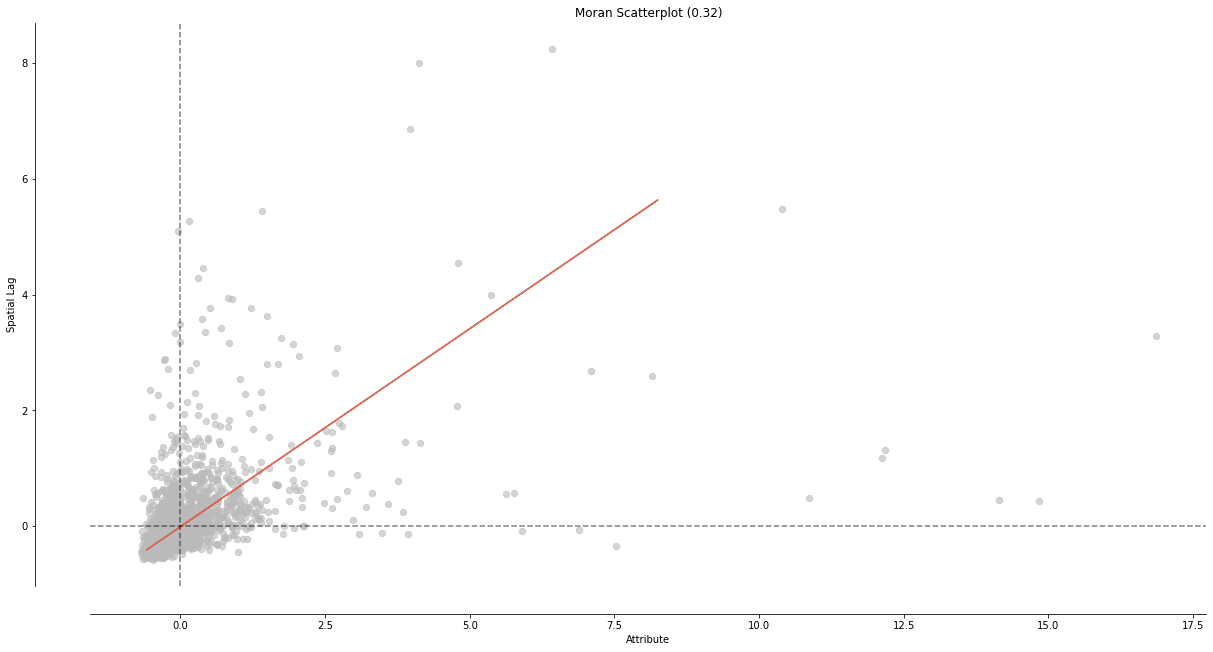

In [4]:
brgys_popn = brgys_popn.dropna(subset=["both_age_6_to_16"])

spatial_weights = weights.Queen.from_dataframe(brgys_popn)
brgys_popn["w_both_age_6_to_16"] = weights.lag_spatial(spatial_weights, brgys_popn["both_age_6_to_16"])

y = brgys_popn["both_age_6_to_16"]
moran = Moran(y, spatial_weights)

fig, ax = moran_scatterplot(moran, aspect_equal=True)
fig.set_figheight(20)
fig.set_figwidth(20)
plt.show();

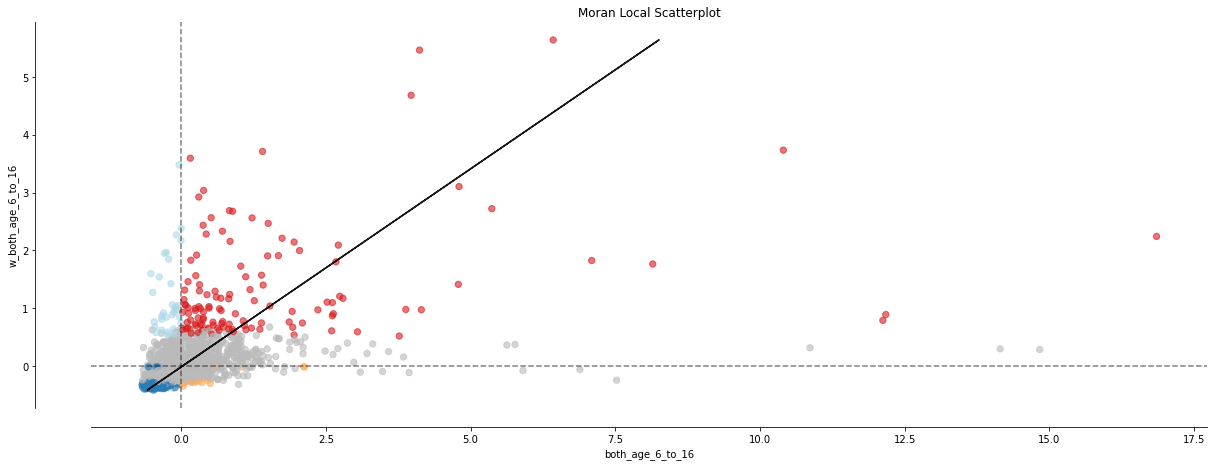

In [5]:
m_local = Moran_Local(y, spatial_weights,keep_simulations = False)

fig, ax = moran_scatterplot(m_local, p=0.05)
fig.set_figheight(20)
fig.set_figwidth(20)
ax.set_xlabel('both_age_6_to_16')
ax.set_ylabel("w_both_age_6_to_16")
plt.show()

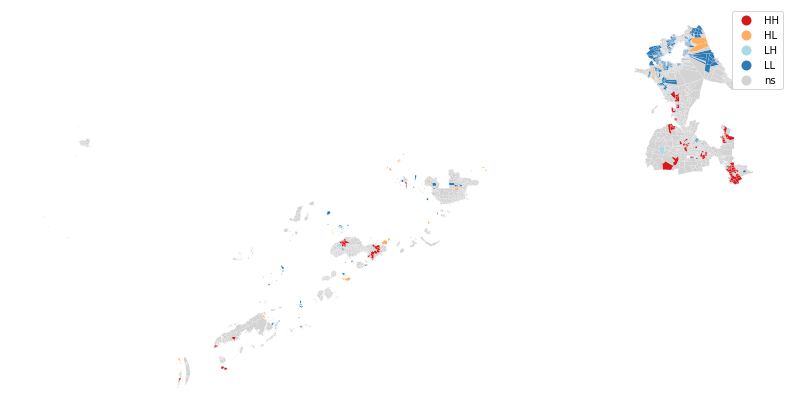

In [6]:
fig, ax = plt.subplots(figsize=(14,12))
lisa_cluster(m_local, brgys_popn, p=0.05, figsize = (20,20),ax=ax)
plt.show();

In [7]:
brgys_popn["local_Moran"]=m_local.Is
brgys_popn["quadrant"]=m_local.q

quadrant = {1:"HH",2:"HL",3:"LL",4:"LH"}
brgys_popn["Quadrant"]=brgys_popn["quadrant"].map(quadrant)
brgys_popn["pvalue"]=m_local.p_sim
brgys_popn["spatial_cluster"]="ns"
cond = brgys_popn["pvalue"]<0.05
brgys_popn.loc[cond,"spatial_cluster"]=brgys_popn.loc[cond,"Quadrant"]

cluster_color = {'HH': 'red',
               'HL': 'orange',
               'LH': 'cyan',
               'LL': 'blue',
               'ns': 'grey'}

brgys_popn["cluster_color"] = brgys_popn["spatial_cluster"].map(cluster_color)

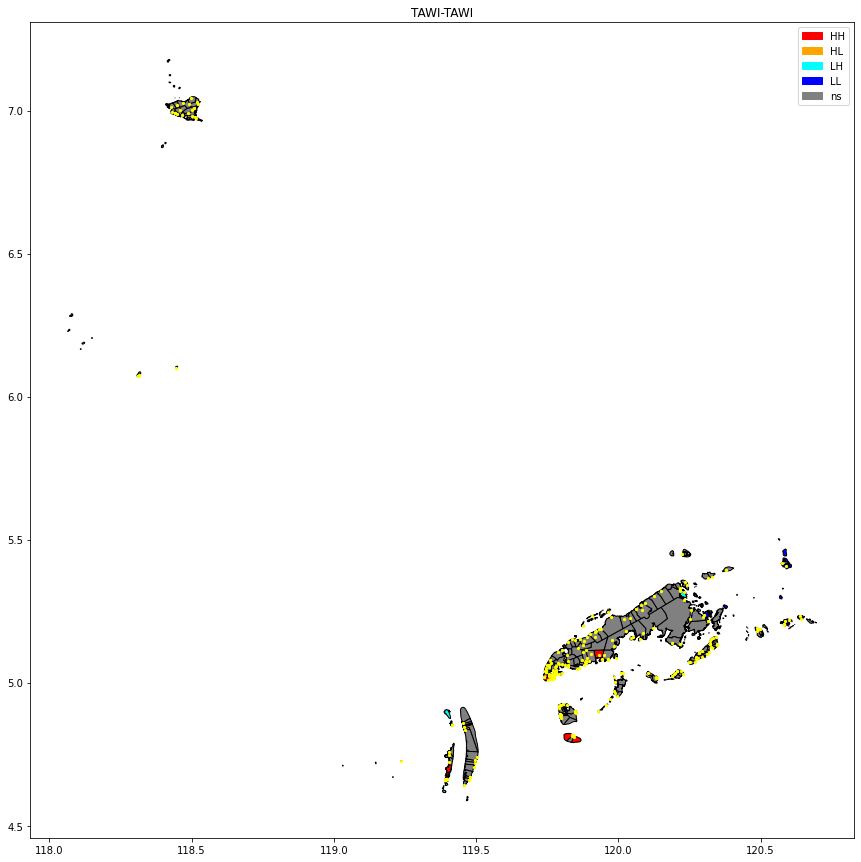

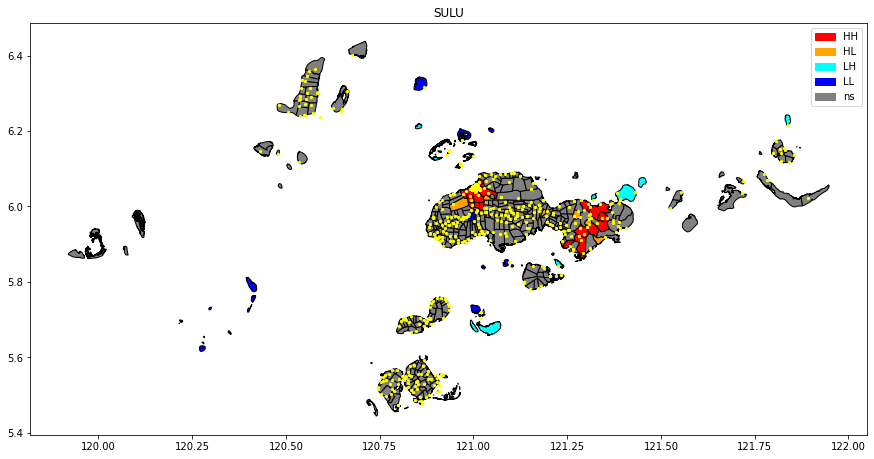

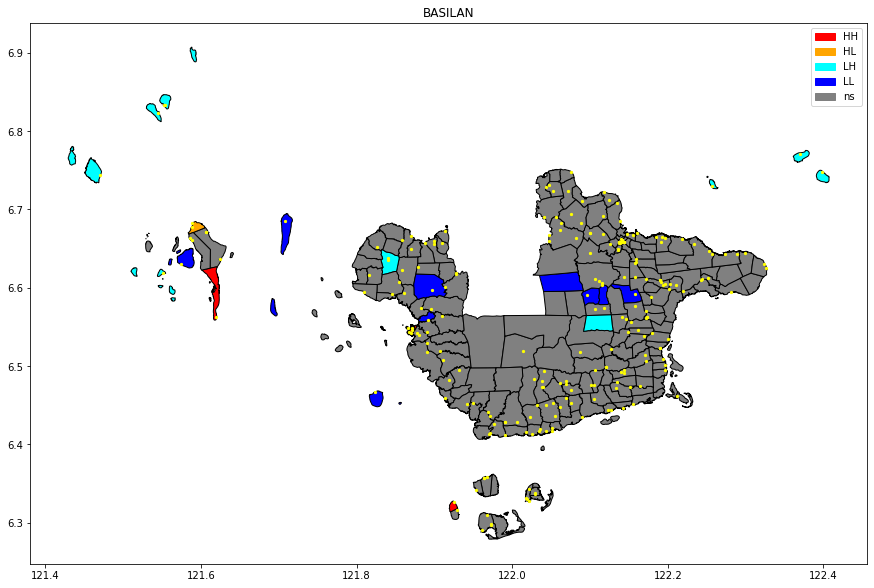

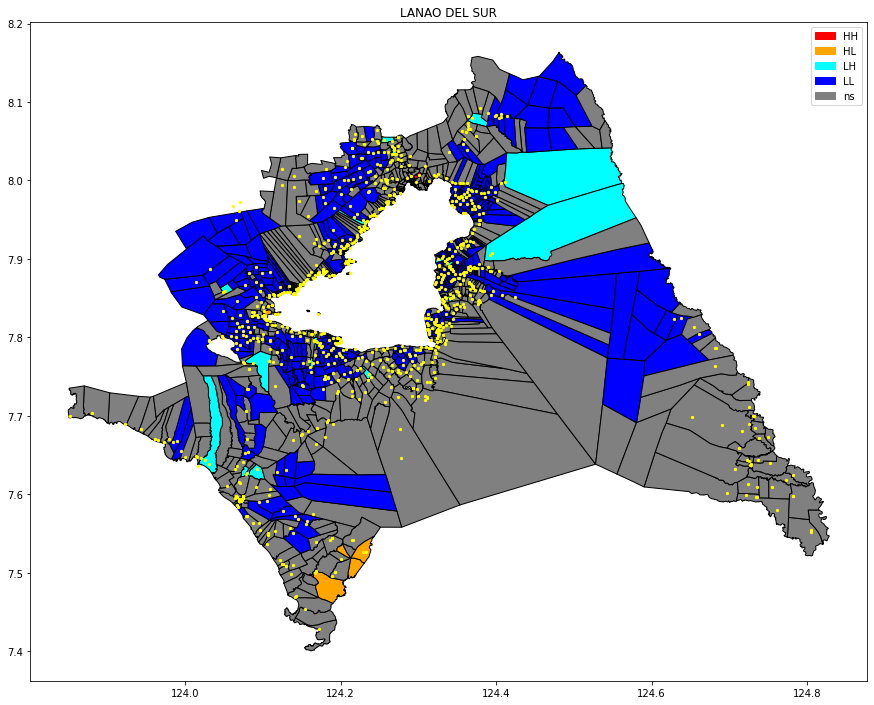

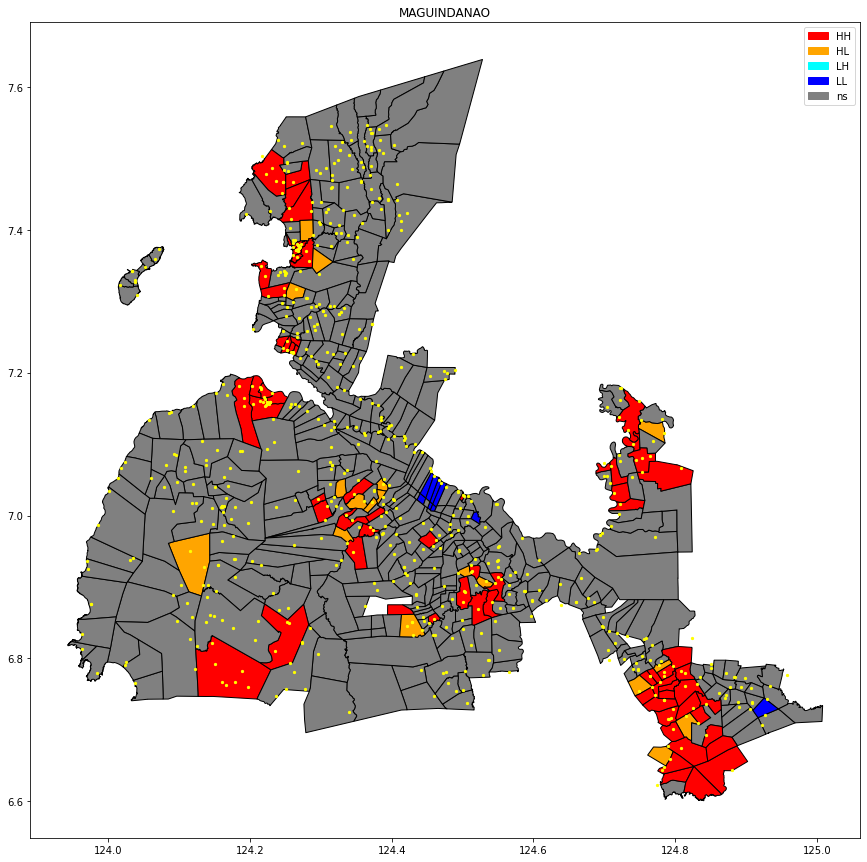

In [8]:
for province in brgys_popn['Pro_Name'].unique():
    cond = brgys_popn['Pro_Name']==province
    base = brgys_popn[cond].plot(figsize=(15, 15),
                                       column="spatial_cluster",
                                       color=brgys_popn.loc[cond,"cluster_color"],
                                       edgecolor="k")
    cond = schools_geodata['PROV']==province
    schools_geodata[cond].dropna()\
                         .plot(ax=base,
                               color="yellow",
                               markersize=5)
    patchList = []
    for key in cluster_color:
            data_key = mpatches.Patch(color=cluster_color[key], label=key)
            patchList.append(data_key)

    plt.legend(handles=patchList)
    plt.title(province)
    plt.show();

In [9]:
cols = ["PSGC_BRGY","both_age_6_to_16","local_Moran","pvalue","spatial_cluster"]
brgys_popn[cols].to_csv(OUTPUT_PATH+"Cluster_spatial_student_popn.csv",index=False)